In [1]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)

# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_title = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_title, species))
# Get waveforms
wf_lizard = wf_list[2][0]
fs_lizard = wf_list[2][1]
wf_title_lizard = wf_list[2][2]

wf_human = wf_list[6][0]
fs_human = wf_list[6][1]
wf_title_human = wf_list[6][2]
del df

Loading Curated Data
Combining into one Dataframe!


In [45]:
species = 'Lizard'

# Set parameters (same for human and lizard)
tauS = 2**12
tau = tauS / 44100 # Everyone uses the same tau
rho = 1

if species == 'Human':
    fs = fs_human
    wf = wf_human
    wf_title = wf_title_human
    # Human parameters
    min_xi = 0.001
    max_xi = 1.5
    delta_xi = 0.001
elif species == 'Lizard':
    fs = fs_lizard
    wf = wf_lizard
    wf_title = wf_title_lizard
    # Lizard parameters
    min_xi = 0.001
    max_xi = 0.1
    delta_xi = 0.0005

In [52]:
# Calculate colossogram 
num_xis = int((max_xi - min_xi) / delta_xi) + 1
xis = np.linspace(min_xi, max_xi, num_xis)

max_xiS = max(xis) * fs
f = rfftfreq(tauS, 1/fs)
# Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
N_segs = int((len(wf) - tauS) / max_xiS)    

coherences = np.zeros((len(f), len(xis)))
print(f"Calculating coherence for wf {wf_title} with {len(xis)} xi values")
for i, xi in enumerate(xis):
    print(f"Getting coherence for xi {i+1}/{len(xis)}")
    coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, rho=rho)[1]

Calculating coherence for wf anole_ACsb18learSOAEwfG4.mat with 199 xi values
Getting coherence for xi 1/199
Getting coherence for xi 2/199
Getting coherence for xi 3/199
Getting coherence for xi 4/199
Getting coherence for xi 5/199
Getting coherence for xi 6/199
Getting coherence for xi 7/199
Getting coherence for xi 8/199
Getting coherence for xi 9/199
Getting coherence for xi 10/199
Getting coherence for xi 11/199
Getting coherence for xi 12/199
Getting coherence for xi 13/199
Getting coherence for xi 14/199
Getting coherence for xi 15/199
Getting coherence for xi 16/199
Getting coherence for xi 17/199
Getting coherence for xi 18/199
Getting coherence for xi 19/199
Getting coherence for xi 20/199
Getting coherence for xi 21/199
Getting coherence for xi 22/199
Getting coherence for xi 23/199
Getting coherence for xi 24/199
Getting coherence for xi 25/199
Getting coherence for xi 26/199
Getting coherence for xi 27/199
Getting coherence for xi 28/199
Getting coherence for xi 29/199
Gett

In [ ]:
# Save/open coherences
species = 'Lizard'
operation = 'open'


if species == 'Human':
    pkl_fn = 'C_xi_decay_coherences_human'
elif species == 'Lizard':
    pkl_fn = 'C_xi_decay_coherences_lizard'

if operation == 'save':
    with open(r"Pickles/" + pkl_fn + '.pkl', 'wb') as file:
        pickle.dump((coherences, f, xis, tau, wf_title, species), file)
elif operation == 'open':
    with open(r"Pickles/" + pkl_fn + '.pkl', 'rb') as file:
        coherences, f, xis, tau, wf_title, species = pickle.load(file)

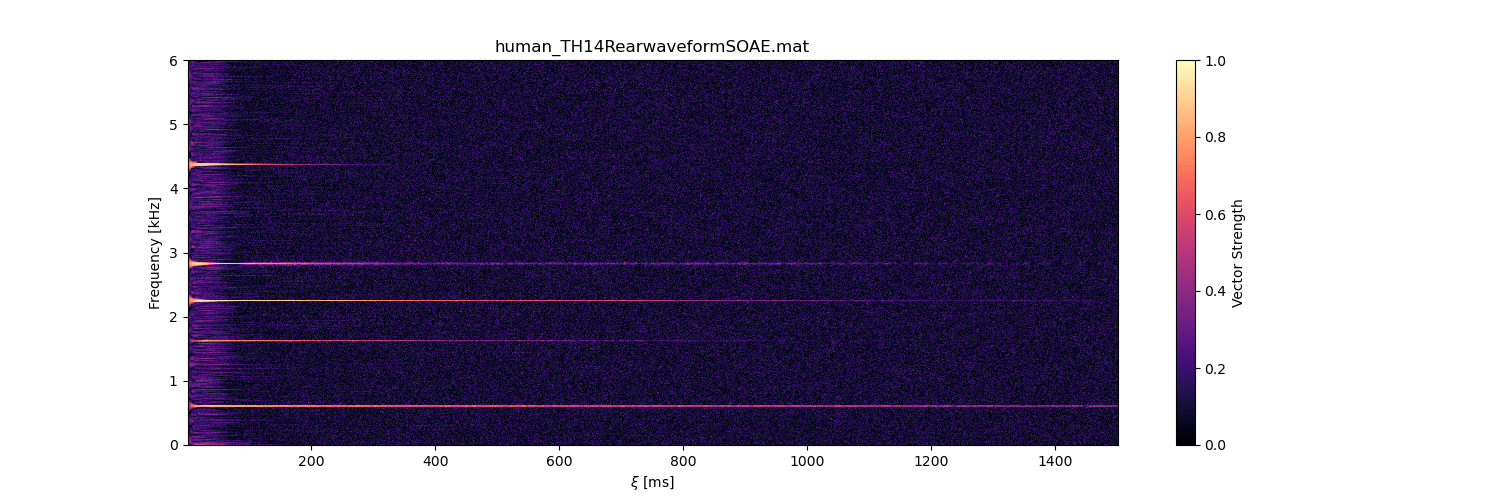

In [59]:
# Visualize colossogram
plt.figure(figsize=(15, 5))
max_khz = 6
plot_colossogram(coherences, f, xis, tau, title=wf_title, max_khz=max_khz, cmap='magma')
plt.savefig(f'C_xi decay colossogram ({species}).png', dpi=300)

In [60]:
# Plot a slice of the colossogram with target bins marked
target_xi = 0.02
xi_idx = np.argmin(np.abs(xis - target_xi))
coherence_slice = coherences[:, xi_idx]
psd = get_welch(wf=wf, fs=fs, tauS=tauS)[1]
psd_xi = get_welch(wf=wf, fs=fs, tauS=tauS, xi=target_xi)[1]

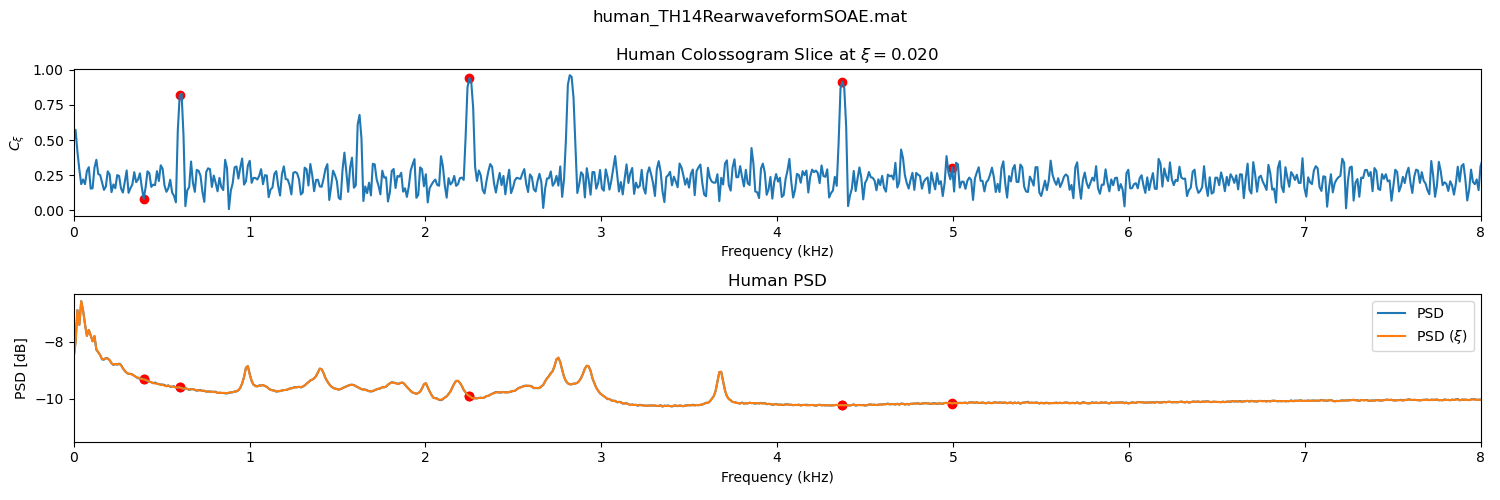

In [61]:
# Cont

if species == 'Lizard':
    peak_freqs = [990, 3670, 2000]
    noise_freqs = [400, 5000]
elif species == 'Human':
    peak_freqs = [603, 2250, 4370]
    noise_freqs = [400, 5000]
    

bin_idxs = []
bin_names = []

for peak_freq in peak_freqs:
    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
    bin_names.append(f"{peak_freq:.0f}Hz Peak")

for noise_freq in noise_freqs:
    bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
    bin_names.append(f"{noise_freq:.0f}Hz Noise")
    
freq_list = peak_freqs + noise_freqs
    
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.title(rf"{species} Colossogram Slice at $\xi={xis[xi_idx]:.3f}$")
plt.plot(f / 1000, coherence_slice)
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, coherence_slice[idx], c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel(r'$C_{\xi}$')
plt.xlim(0, 8)
plt.subplot(2, 1, 2)
plt.title(rf"{species} PSD")
plt.plot(f / 1000, np.log10(psd), label='PSD')
plt.plot(f / 1000, np.log10(psd_xi), label=r'PSD ($\xi$)')
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, np.log10(psd[idx]), c='r')
    plt.scatter(f[idx] / 1000, np.log10(psd_xi[idx]), c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel("PSD [dB]")  
plt.legend()
plt.suptitle(wf_title)
plt.xlim(0, 8)
plt.tight_layout()
plt.savefig(f'C_xi decay target bins ({species}).png', dpi=300)
plt.show()



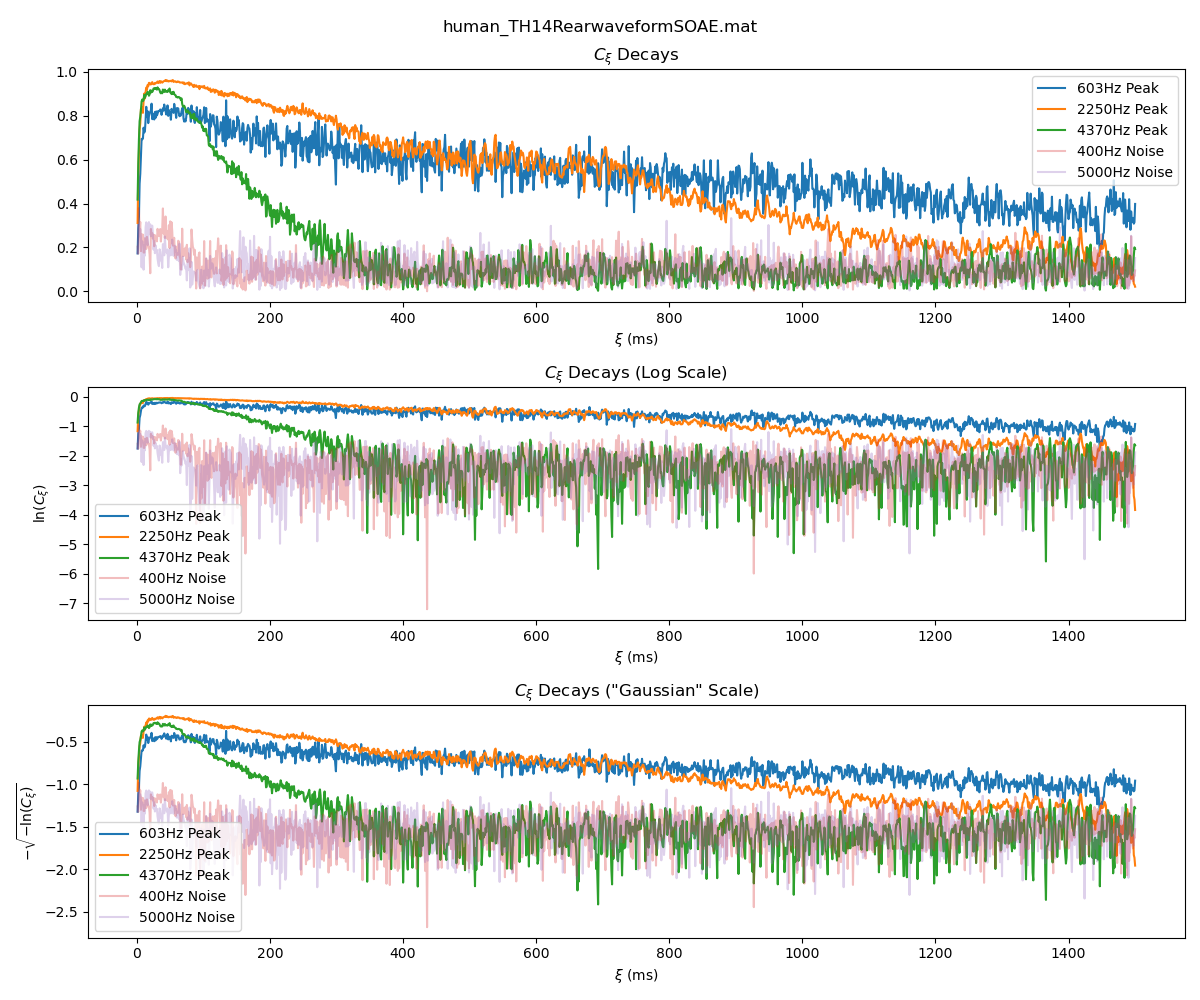

In [65]:
# Plot decays on various scales
plt.figure(figsize=(12, 10))

plt.suptitle(wf_title)
for scale, idx in zip(['normal', 'log', 'gauss'], [1, 2, 3]):
    plt.subplot(3, 1, idx)
    for f_idx, bin_name in zip(bin_idxs, bin_names):
        coherence_falloff = coherences[f_idx, :]
        title = r"$C_{\xi}$ Decays"
        if scale == 'gauss':
            coherence_falloff = -np.sqrt(-np.log(coherence_falloff))
            plt.ylabel(r'$-\sqrt{-\ln(C_{\xi})}$')
            title+= " (\"Gaussian\" Scale)"
        elif scale == 'log':
            coherence_falloff = np.log(coherence_falloff)
            plt.ylabel(r'$\ln(C_{\xi})$')
            plt.title("Log Scale")
            title+= " (Log Scale)"
        plt.title(title)
        alpha=1
        if 'Noise' in bin_name:
            alpha=0.3
        plt.plot(xis*1000, coherence_falloff, label=bin_name, alpha=alpha)
    plt.xlabel(r'$\xi$ (ms)')
    plt.legend()
plt.tight_layout()
plt.savefig(f'C_xi decays ({species}).png', dpi=300)
plt.show()
    